In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import time
import deepcallib

c:\Users\Mark\anaconda3\envs\ModifiedCALenv\lib\site-packages\pyglet\image\codecs\wic.py:406: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))
c:\Users\Mark\anaconda3\envs\ModifiedCALenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# STL_Folder = "D:/archive/members/mark/accuracy_testing/128x128/STL_Files/"
# VTBOutputFolder = "D:/archive/members/mark/accuracy_testing/128x128/VTB/"
# MLOutputFolder = "D:/archive/members/mark/accuracy_testing/128x128/ML/"
# PreProjectionsOutputFolder = "D:/archive/members/mark/accuracy_testing/128x128/preProjections"
# ML_Model = "D:/archive/members/mark/accuracy_testing/128x128/model_128x128_200.pth"
STL_Folder = "./accuracy_testing/128x128/STL_Files/"
VTBOutputFolder = "./accuracy_testing/128x128/VTB/"
MLOutputFolder = "./accuracy_testing/128x128/ML/"
PreProjectionsOutputFolder = "./accuracy_testing/128x128/preProjections/"
ML_Model = "./model_128x128_REVERSED_200.pth"
dimension = [128, 128]

enable_rotation_optimization = False
error_function = deepcallib.total_dose_dif # array, array => number
num_angles = 360
n_iter  = 20
d_h = 0.85
d_l = 0.6
filterType = 'hamming' #ramlak
method = 'OSMO'
resolution = dimension[1]
batch_size = 90

start_time = time.time()

"""
Input: folder with test STL files

params:
error function (MSE, voxel count, jacard, surface error)



steps:
do VTB projections, save in folder
do ML projections, save in folder
get preProjection, save in folder

caclulate rotations number for VTB
caclulate rotations number for ML
caclulate rotations number for preProjections

Measure error


"""


'\nInput: folder with test STL files\n\nparams:\nerror function (MSE, voxel count, jacard, surface error)\n\n\n\nsteps:\ndo VTB projections, save in folder\ndo ML projections, save in folder\nget preProjection, save in folder\n\ncaclulate rotations number for VTB\ncaclulate rotations number for ML\ncaclulate rotations number for preProjections\n\nMeasure error\n\n\n'

# PART1 DATA GENERATION

In [3]:
# prepare for data generation


STL_files = os.listdir(STL_Folder)
print(f"we will use these STL files: {STL_files}")

def clear_folder(folder):
    # clear all output image sequences FOR TESTING PURPOSES
    # DELETE THIS WHEN DOING A REAL DATA GENERATION RUN
    for f in os.listdir(folder):
        os.remove(os.path.join(folder, f))

clear_folder(PreProjectionsOutputFolder)
clear_folder(MLOutputFolder)
clear_folder(VTBOutputFolder)

deepcallib.batch_rotate_stl_files(STL_Folder, STL_Folder)



we will use these STL files: ['pikachu.stl']
Rotated: pikachu.stl


Generating data
optimizing: ./accuracy_testing/128x128/STL_Files/pikachu.stl
('./accuracy_testing/128x128/STL_Files', 'pikachu.stl')


c:\Users\Mark\anaconda3\envs\ModifiedCALenv\lib\site-packages\vamtoolbox\util\data.py:116: ComplexWarning: Casting complex values to real discards the imaginary part
  return x_filtered.astype(float)


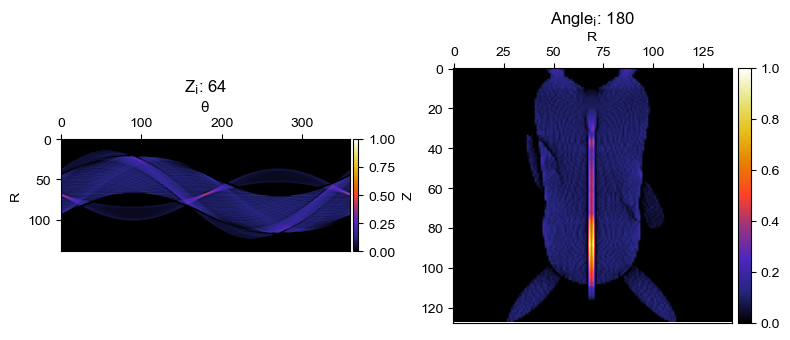

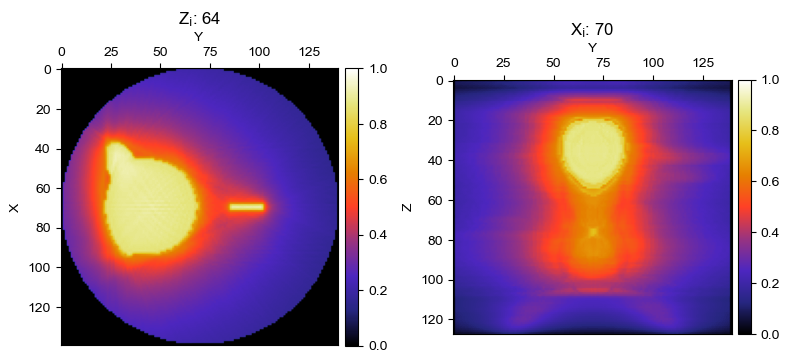

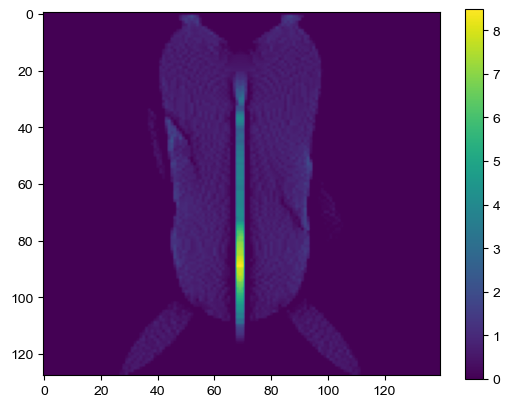

output folder: ./accuracy_testing/128x128/VTB/
output prefix: pikachu
save path = ./accuracy_testing/128x128/VTB/pikachu0000.png
save path = ./accuracy_testing/128x128/VTB/pikachu0001.png
save path = ./accuracy_testing/128x128/VTB/pikachu0002.png
save path = ./accuracy_testing/128x128/VTB/pikachu0003.png
save path = ./accuracy_testing/128x128/VTB/pikachu0004.png
save path = ./accuracy_testing/128x128/VTB/pikachu0005.png
save path = ./accuracy_testing/128x128/VTB/pikachu0006.png
save path = ./accuracy_testing/128x128/VTB/pikachu0007.png
save path = ./accuracy_testing/128x128/VTB/pikachu0008.png
save path = ./accuracy_testing/128x128/VTB/pikachu0009.png
save path = ./accuracy_testing/128x128/VTB/pikachu0010.png
save path = ./accuracy_testing/128x128/VTB/pikachu0011.png
save path = ./accuracy_testing/128x128/VTB/pikachu0012.png
save path = ./accuracy_testing/128x128/VTB/pikachu0013.png
save path = ./accuracy_testing/128x128/VTB/pikachu0014.png
save path = ./accuracy_testing/128x128/VTB/pi

In [4]:
# 1. VTB + Pre Projections
vtb_start_time = time.time()

import vamtoolbox as vam


optimizer_params = vam.optimize.Options(method=method, n_iter=n_iter, d_h = d_h, d_l = d_l, filter=filterType)
angles = np.linspace(0, 360 - 360/num_angles, num_angles)
iconfig0=vam.imagesequence.ImageConfig(image_dims=(dimension[0],dimension[1]),array_offset=0)
# path sanity check

files = []
for file in STL_files:
    file = STL_Folder + file
    files.append(file)

print("Generating data")
deepcallib.generatedata(files, resolution, angles, optimizer_params, dimension, VTBOutputFolder, PreProjectionsOutputFolder)

vtb_end_time = time.time()

print(f"VTB took {vtb_end_time - vtb_start_time} seconds")

In [5]:

# 2. ML
ML_start_time = time.time()

# run model on pre projections
deepcallib.generatedata_ML(ML_Model, PreProjectionsOutputFolder, MLOutputFolder, batch_size, use_cpu = True)

ML_end_time = time.time()

print(f"ML took {ML_end_time - ML_start_time} seconds")


No GPUs available. PyTorch is using CPU.
PyTorch is using CPU.
ML took 36.968188762664795 seconds


# PART2 ACCURACY

loading images from folder ./accuracy_testing/128x128/VTB/


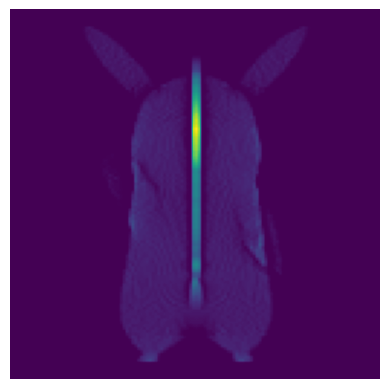

showing first loaded image
loading images from folder ./accuracy_testing/128x128/ML/


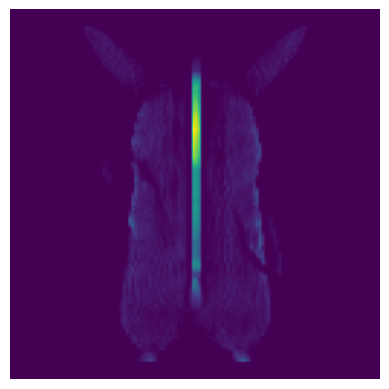

showing first loaded image
loading images from folder ./accuracy_testing/128x128/preProjections/


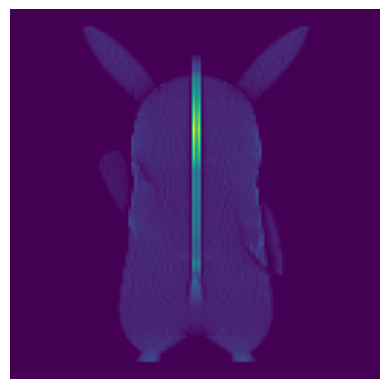

showing first loaded image


In [6]:


projections_VTB = deepcallib.load_png_to_numpy_array("./accuracy_testing/128x128/VTB/", rotate=True)

projections_ML = deepcallib.load_png_to_numpy_array('./accuracy_testing/128x128/ML/', rotate=True)

projections_NO_opt = deepcallib.load_png_to_numpy_array('./accuracy_testing/128x128/preProjections/', rotate=True)


In [7]:
# Generate the 3d voxels for ground truth and reconstruction

stl_file_name = "./accuracy_testing/128x128/STL_Files/pikachu.stl"
resolution=projections_ML.shape[2]

reconstruction_ML = deepcallib.inverse_radon(projections=projections_ML, STLfile_name=stl_file_name, resolution=resolution)
reconstruction_NO_opt = deepcallib.inverse_radon(projections=projections_NO_opt, STLfile_name=stl_file_name, resolution=resolution)
reconstruction_VTB = deepcallib.inverse_radon(projections=projections_VTB, STLfile_name=stl_file_name, resolution=resolution)

ground_truth = vam.geometry.TargetGeometry(stlfilename=stl_file_name, resolution=resolution).array
ground_truth = deepcallib.expand_3d_numpy_array(ground_truth, reconstruction_ML.shape)
# ground_truth = np.flip(ground_truth, axis=0)
# ground_truth = np.flip(ground_truth, axis=1)
ground_truth = np.flip(ground_truth, axis=2)
# ground_truth = ground_truth[:][::-1]
# print(ground_truth.shape)


checking 0 to 4
checking -0.19999999999999996 to 1.8
checking 0.10000000000000009 to 1.1
checking 0.2500000000000001 to 0.7500000000000001
checking 0.3250000000000001 to 0.5750000000000002


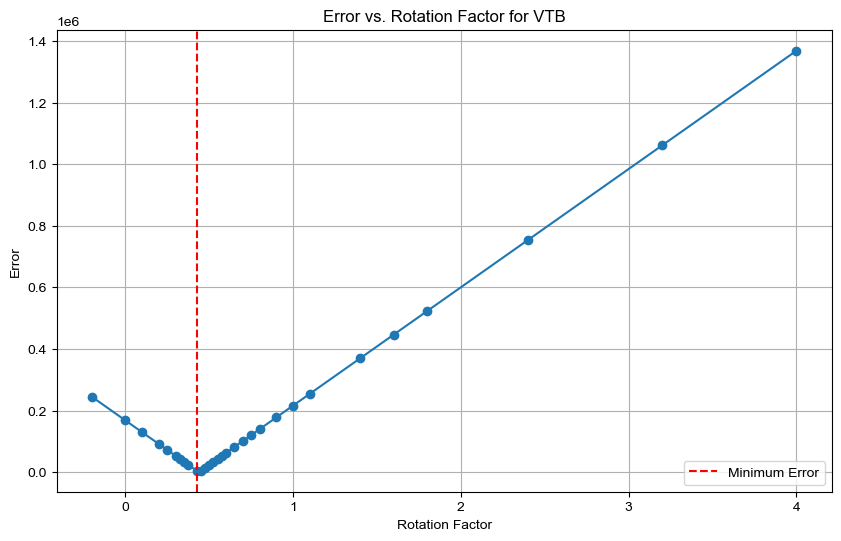

checking 0 to 4
checking -0.19999999999999996 to 1.8
checking 0.10000000000000009 to 1.1
checking 0.2500000000000001 to 0.7500000000000001
checking 0.3750000000000001 to 0.6250000000000001


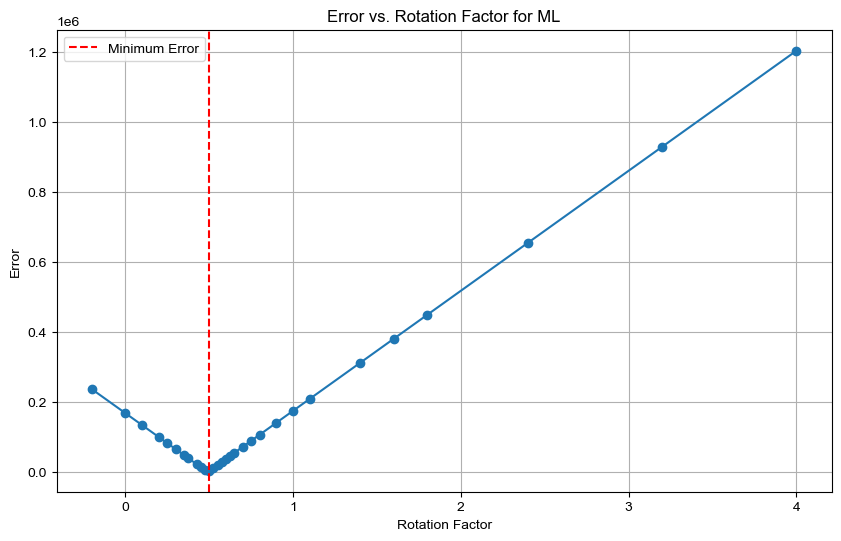

checking 0 to 4
checking -1.0 to 1.0
checking -0.2999999999999998 to 0.7000000000000002
checking 0.050000000000000266 to 0.5500000000000003
checking 0.2250000000000003 to 0.4750000000000003


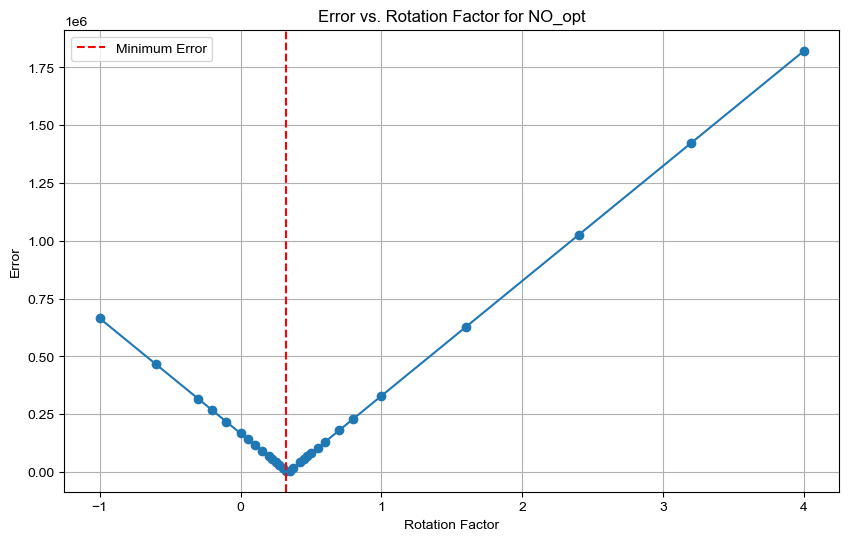

best number of rotations for VTB: 0.42500000000000016
best number of rotations for ML: 0.5000000000000001
best number of rotations for no optimization: 0.3250000000000003


In [8]:


opt_rotations_VTB = deepcallib.calculate_optimal_rotations(ground_truth, reconstruction_VTB, error_function, name="VTB", initial_range=[0, 4])
opt_rotations_ML = deepcallib.calculate_optimal_rotations(ground_truth, reconstruction_ML, error_function, name="ML", initial_range=[0, 4])
opt_rotations_NO_opt = deepcallib.calculate_optimal_rotations(ground_truth, reconstruction_NO_opt, error_function, name="NO_opt", initial_range=[0, 4])

print(f"best number of rotations for VTB: {opt_rotations_VTB}")
print(f"best number of rotations for ML: {opt_rotations_ML}")
print(f"best number of rotations for no optimization: {opt_rotations_NO_opt}")


################################################################################################
# best number of rotations for VTB: 1.4500000000000002
# best number of rotations for ML: 1.6750000000000003
# best number of rotations for no optimization: 1.0250000000000001

In [9]:
# best_number_of_rotation_VTB = 1.4500000000000002
# best_number_of_rotation_ML = 1.6750000000000003
# best_number_of_rotation_NO_opt = 1.0250000000000001

best_number_of_rotation_NO_opt = 0.4500000000000001
# best_number_of_rotation_VTB = 0.75
best_number_of_rotation_ML = 0.6500000000000001

# deepcallib.plot(np.array(ground_truth), d_l=0.001, d_h=1)

# NO_opt = deepcallib.round_3d_array(reconstruction_NO_opt, round_down_threshold=d_l, round_up_threshold=d_h)
# NO_opt = deepcallib.round_3d_array(reconstruction_NO_opt * best_number_of_rotation_NO_opt, round_down_threshold=d_l, round_up_threshold=d_h)  
# deepcallib.plot(np.array(NO_opt), d_l=0.001, d_h=1)

# VTB_opt = deepcallib.round_3d_array(reconstruction_VTB, round_down_threshold=d_l, round_up_threshold=d_h)  
# VTB_opt = deepcallib.round_3d_array(reconstruction_VTB * best_number_of_rotation_VTB, round_down_threshold=d_l, round_up_threshold=d_h)  
# deepcallib.plot(np.array(VTB_opt), d_l=0.001, d_h=1)

ML_opt = deepcallib.round_3d_array(reconstruction_ML*opt_rotations_ML, round_down_threshold=d_l, round_up_threshold=d_h)  
# ML_opt = deepcallib.round_3d_array(reconstruction_ML * best_number_of_rotation_ML, round_down_threshold=d_l, round_up_threshold=d_h)  
deepcallib.plot(np.array(ML_opt), d_l=0.001, d_h=1)

c:\Users\Mark\anaconda3\envs\ModifiedCALenv\lib\site-packages\vedo\colors.py:778: RuntimeWarning: invalid value encountered in double_scalars
  values = [(value - vmin) / (vmax - vmin)]
